In [1]:
___Author___='LumberJack Jyss'

In [2]:
print('Global Optimized LumberJack Equities Method\n°OoO_FOREX_Oo0°\nLumberJack Jyss 5779(c)')

Global Optimized LumberJack Equities Method
°OoO_FOREX_Oo0°
LumberJack Jyss 5779(c)


currencies = ['EURJPY=X', 'GBPJPY=X', 'USDJPY=X','GBPUSD=X','BTCUSD=X','ETHUSD=X','GBPEUR=X',\
             'GBPSGD=X','GBPSEK=X','GBPSAR=X','CADUSD=X','CADJPY=X','AUDUSD=X','NZDUSD=X',\
             'NZDGBP=X','NZDEUR=X','AUDGBP=X','AUDEUR=X',]
daily_currency_prices = YahooFinancials(currencies).get_historical_price_data(start,end,'daily')
temp_df = pd.DataFrame.from_dict(daily_currency_prices.values()).T

In [3]:
print('Importation des librairies...')
import numpy as np
import pandas as pd
import pandas_datareader as web
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from yahoofinancials import YahooFinancials
from sklearn.metrics import mean_squared_error
from math import sqrt
print('Librairies importées')

Importation des librairies...


Using TensorFlow backend.


Librairies importées


In [4]:
start = '2014-01-28'
end = '2019-05-24'

In [5]:
currencies = ['GBPUSD=X']
daily_currency_prices = YahooFinancials(currencies).get_historical_price_data(start,end,'daily')

In [6]:
temp_df = pd.DataFrame.from_dict(daily_currency_prices.values()).T

In [7]:
gbpusd = pd.DataFrame.from_dict(temp_df.iloc[4,0])

In [8]:
df = pd.DataFrame()
df['Date'] = gbpusd['formatted_date']
df['High'] = gbpusd['high']
df['Low'] = gbpusd['low']
df['Open'] = gbpusd['open']
df['Close'] = gbpusd['close']
#df['Volume'] = gbpusd['volume']
df['Adj Close'] = gbpusd['adjclose']

In [9]:
delta = round(df.shape[0])
bloc1 = round(delta*0.8)
bloc2 = delta - bloc1
print("Période d'étude : ",delta)
print('Sur un découpage 80% - 20% de la période : ')
print('Bloc 1 : ',bloc1,' jours \nBloc 2 :',bloc2,' jours')

Période d'étude :  1389
Sur un découpage 80% - 20% de la période : 
Bloc 1 :  1111  jours 
Bloc 2 : 278  jours


In [10]:
df.head()

,Date,High,Low,Open,Close,Adj Close
0,2014-01-28,1.662124,1.654287,1.657523,1.657495,1.657495
1,2014-01-29,1.660550,1.652892,1.656891,1.657001,1.657001
2,2014-01-30,1.656589,1.644899,1.655821,1.655903,1.655903
3,2014-01-31,1.649947,1.643169,1.649430,1.649838,1.649838
4,2014-02-03,1.643791,1.632706,1.643791,1.643791,1.643791


In [11]:
df.tail()

,Date,High,Low,Open,Close,Adj Close
1384,2019-05-19,1.275754,1.271682,1.273026,1.273156,1.273156
1385,2019-05-20,1.279427,1.268617,1.272783,1.272912,1.272912
1386,2019-05-21,NaN,NaN,NaN,NaN,NaN
1387,2019-05-22,1.268343,1.260589,1.266336,1.266416,1.266416
1388,2019-05-24,1.270567,1.265566,1.266255,1.267491,1.267491


In [12]:
df.shape

(1389, 6)

In [78]:
dataset = df.copy()
dataset = dataset.drop(dataset[['Close','Date']],axis=1)
dataset.rename(columns={'Adj Close':'Close'}, inplace=True)
dataset.fillna(dataset.mean(), inplace=True)

In [79]:
dataset.isnull().sum(),type(dataset)

(High     0
 Low      0
 Open     0
 Close    0
 dtype: int64, pandas.core.frame.DataFrame)

In [80]:
dataset.describe()

,High,Low,Open,Close
count,1389.000000,1389.000000,1389.000000,1389.000000
mean,1.423744,1.413996,1.419030,1.419056
std,0.142088,0.142614,0.142383,0.142378
min,1.208751,1.199515,1.203746,1.203935
25%,1.304019,1.295505,1.300559,1.300559
50%,1.391595,1.380662,1.386501,1.386194
75%,1.543496,1.532896,1.536807,1.536665
max,1.718715,1.714237,1.716237,1.716090


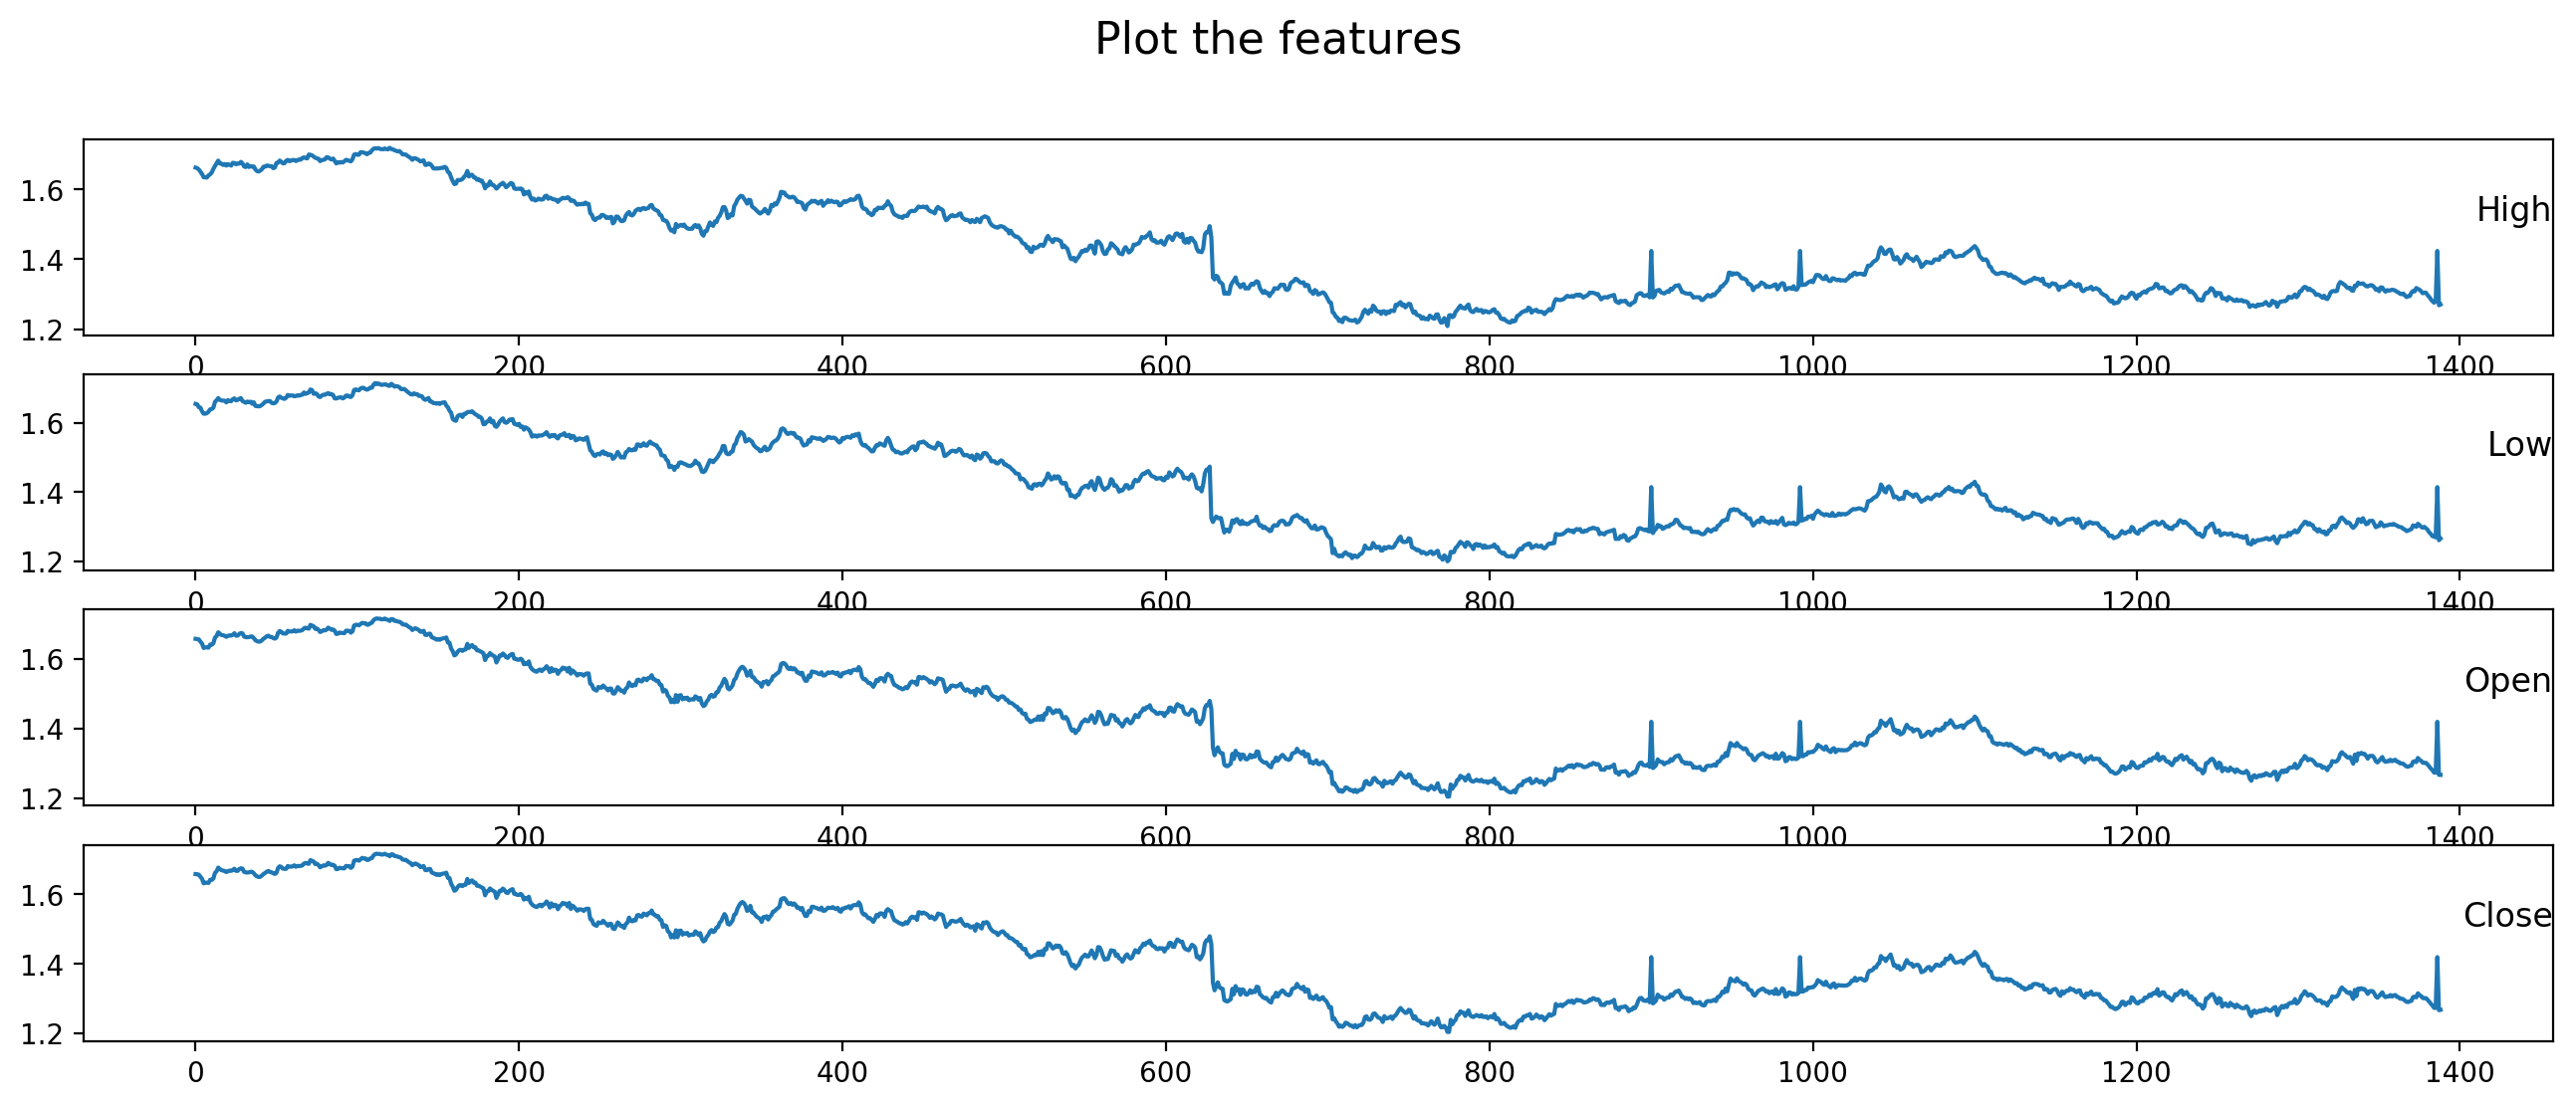

In [81]:
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3]
i = 1
# plot each column
plt.figure(figsize=(16,6),dpi=200)
for group in groups:
    plt.suptitle('Plot the features',fontsize=16)
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

In [82]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [83]:
# ensure all data is float
values = values.astype('float32')

In [84]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [85]:
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

In [86]:
# drop columns we don't want to predict
reframed.drop(reframed.columns[[3,4,5,6]], axis=1, inplace=True)
reframed.tail()

,var1(t-1),var2(t-1),var3(t-1),var4(t)
1384,0.139553,0.141086,0.148375,0.135156
1385,0.131387,0.140206,0.135182,0.134681
1386,0.138589,0.134251,0.134708,0.420032
1387,0.421583,0.416692,0.420074,0.121997
1388,0.116856,0.118654,0.122128,0.124097


In [87]:
# split into train and test sets
values = reframed.values
train = values[:bloc1, :]
test = values[bloc1:, :]

In [88]:
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [89]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [90]:
train_X.shape, train_y.shape, test_X.shape, test_y.shape

((1111, 1, 3), (1111,), (277, 1, 3), (277,))

In [91]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences = True))
model.add(LSTM(units = 20, return_sequences = True))
model.add(Dropout(0.3))
model.add(LSTM(units = 10))
model.add(Dropout(0.4))  
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
#model.compile(loss='mae', optimizer='adam')

In [92]:
# fit network
history = model.fit(train_X, train_y, epochs=200, batch_size=72, validation_data=(test_X, test_y), verbose=1, shuffle=False)

Train on 1111 samples, validate on 277 samples
Epoch 1/200
1111/1111 [==============================] - 3s 3ms/step - loss: 0.2980 - val_loss: 0.0293
Epoch 2/200
1111/1111 [==============================] - 0s 83us/step - loss: 0.2652 - val_loss: 0.0191
Epoch 3/200
1111/1111 [==============================] - 0s 84us/step - loss: 0.2293 - val_loss: 0.0094
Epoch 4/200
1111/1111 [==============================] - 0s 82us/step - loss: 0.1838 - val_loss: 0.0024
Epoch 5/200
1111/1111 [==============================] - 0s 81us/step - loss: 0.1298 - val_loss: 0.0047
Epoch 6/200
1111/1111 [==============================] - 0s 84us/step - loss: 0.0753 - val_loss: 0.0202
Epoch 7/200
1111/1111 [==============================] - 0s 84us/step - loss: 0.0535 - val_loss: 0.0272
Epoch 8/200
1111/1111 [==============================] - 0s 86us/step - loss: 0.0405 - val_loss: 0.0208
Epoch 9/200
1111/1111 [==============================] - 0s 83us/step - loss: 0.0429 - val_loss: 0.0169
Epoch 10/200
1111/

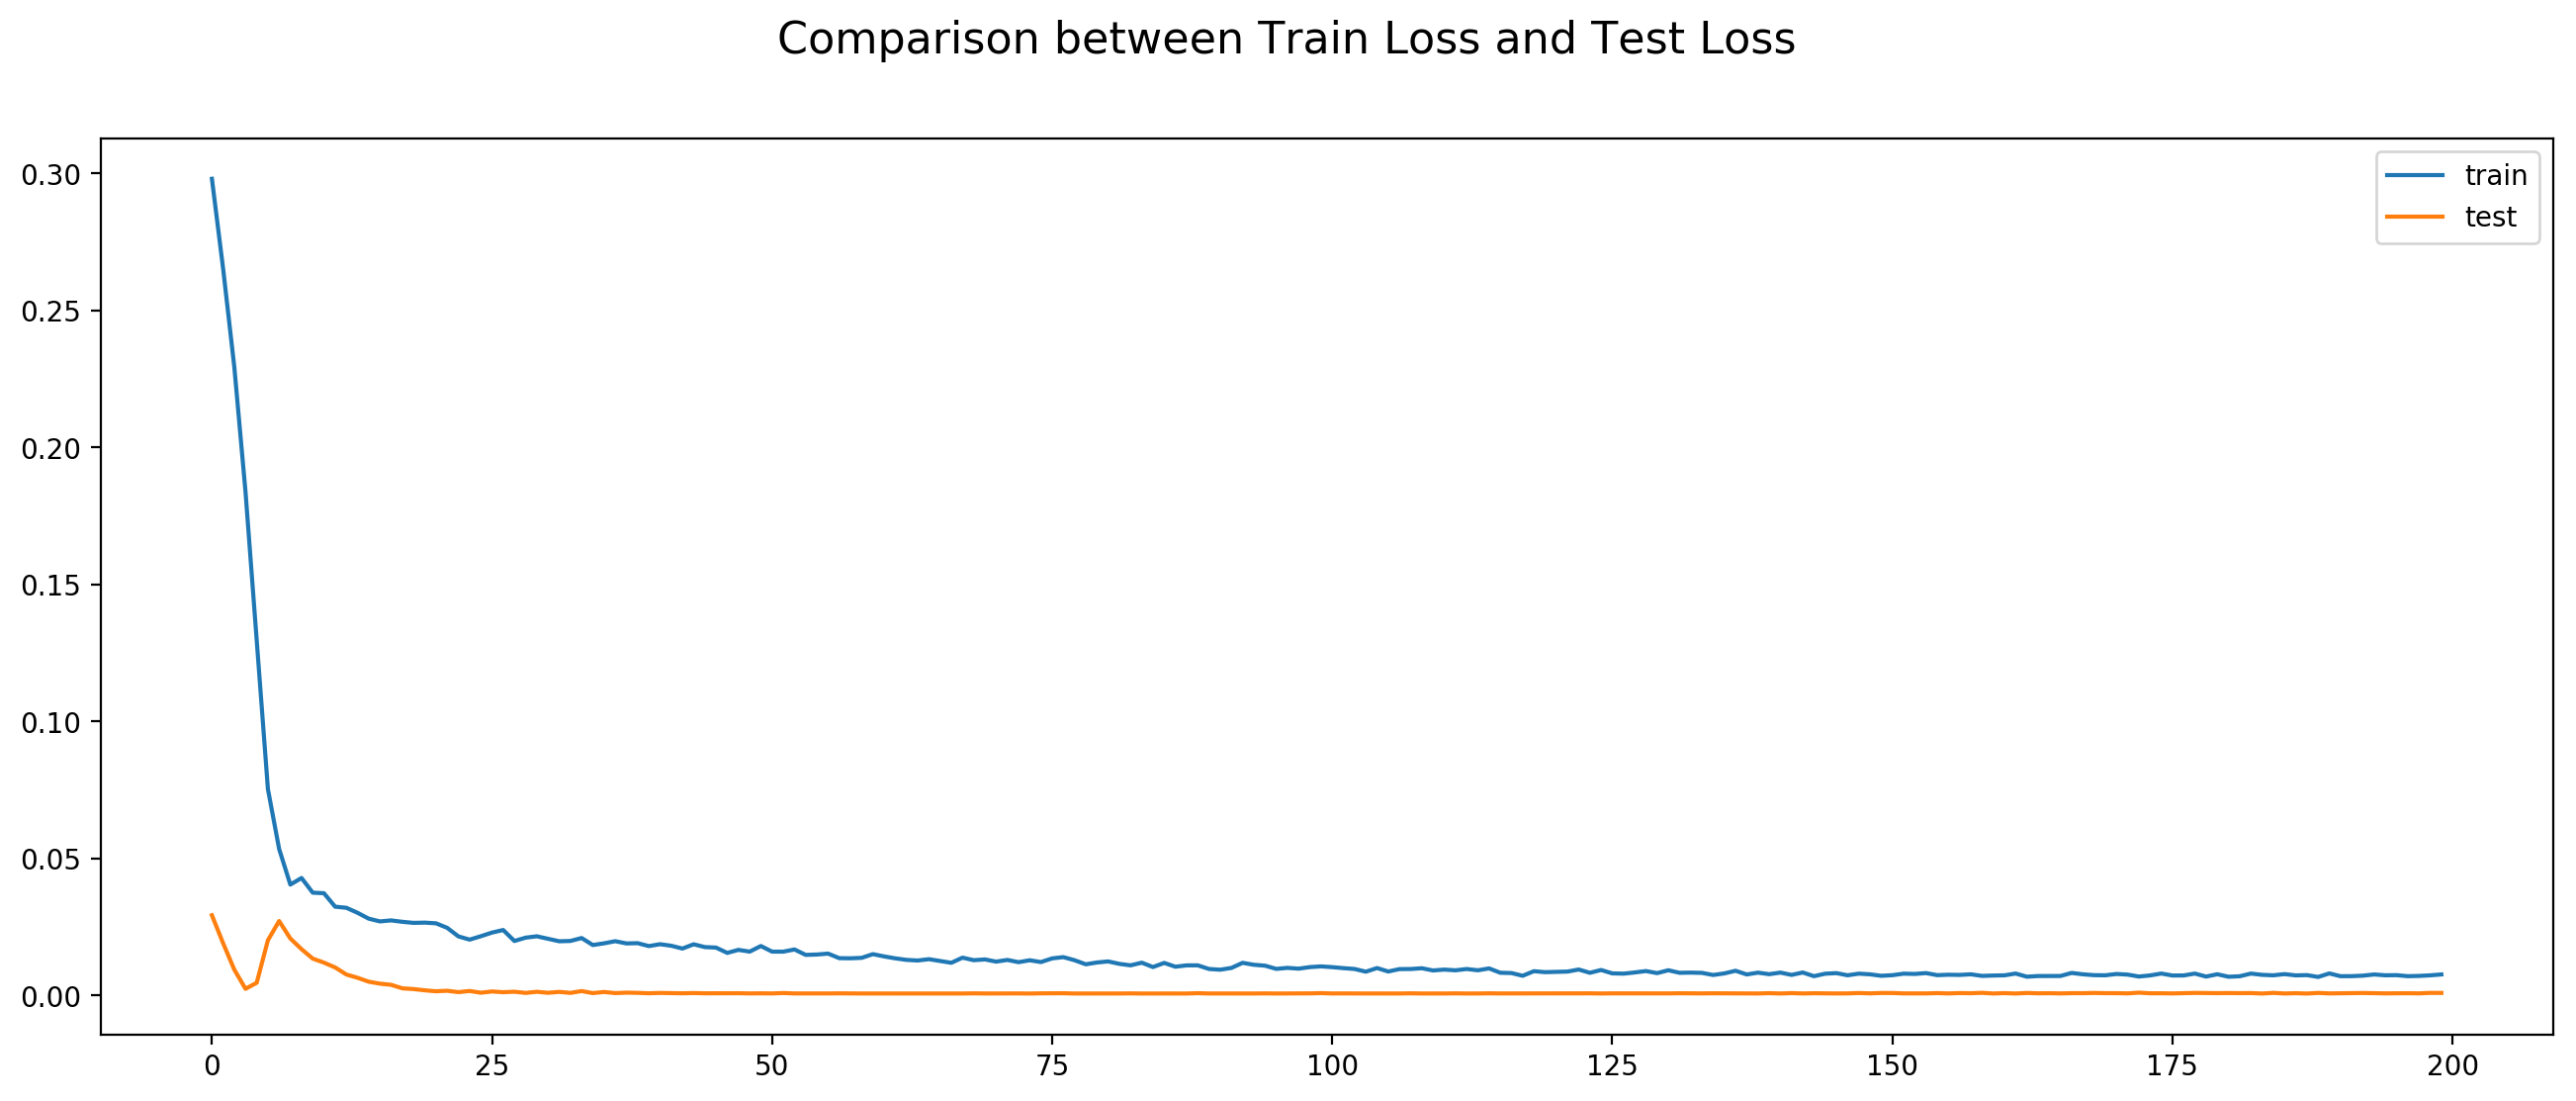

In [93]:
# plot history
plt.figure(figsize=(16,6),dpi=200)
#plt.xlim(1370,1385 )
#plt.ylim(1.25,1.35)
plt.suptitle('Comparison between Train Loss and Test Loss',fontsize=16)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [94]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

In [112]:
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -3:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

In [113]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -7:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [114]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.016


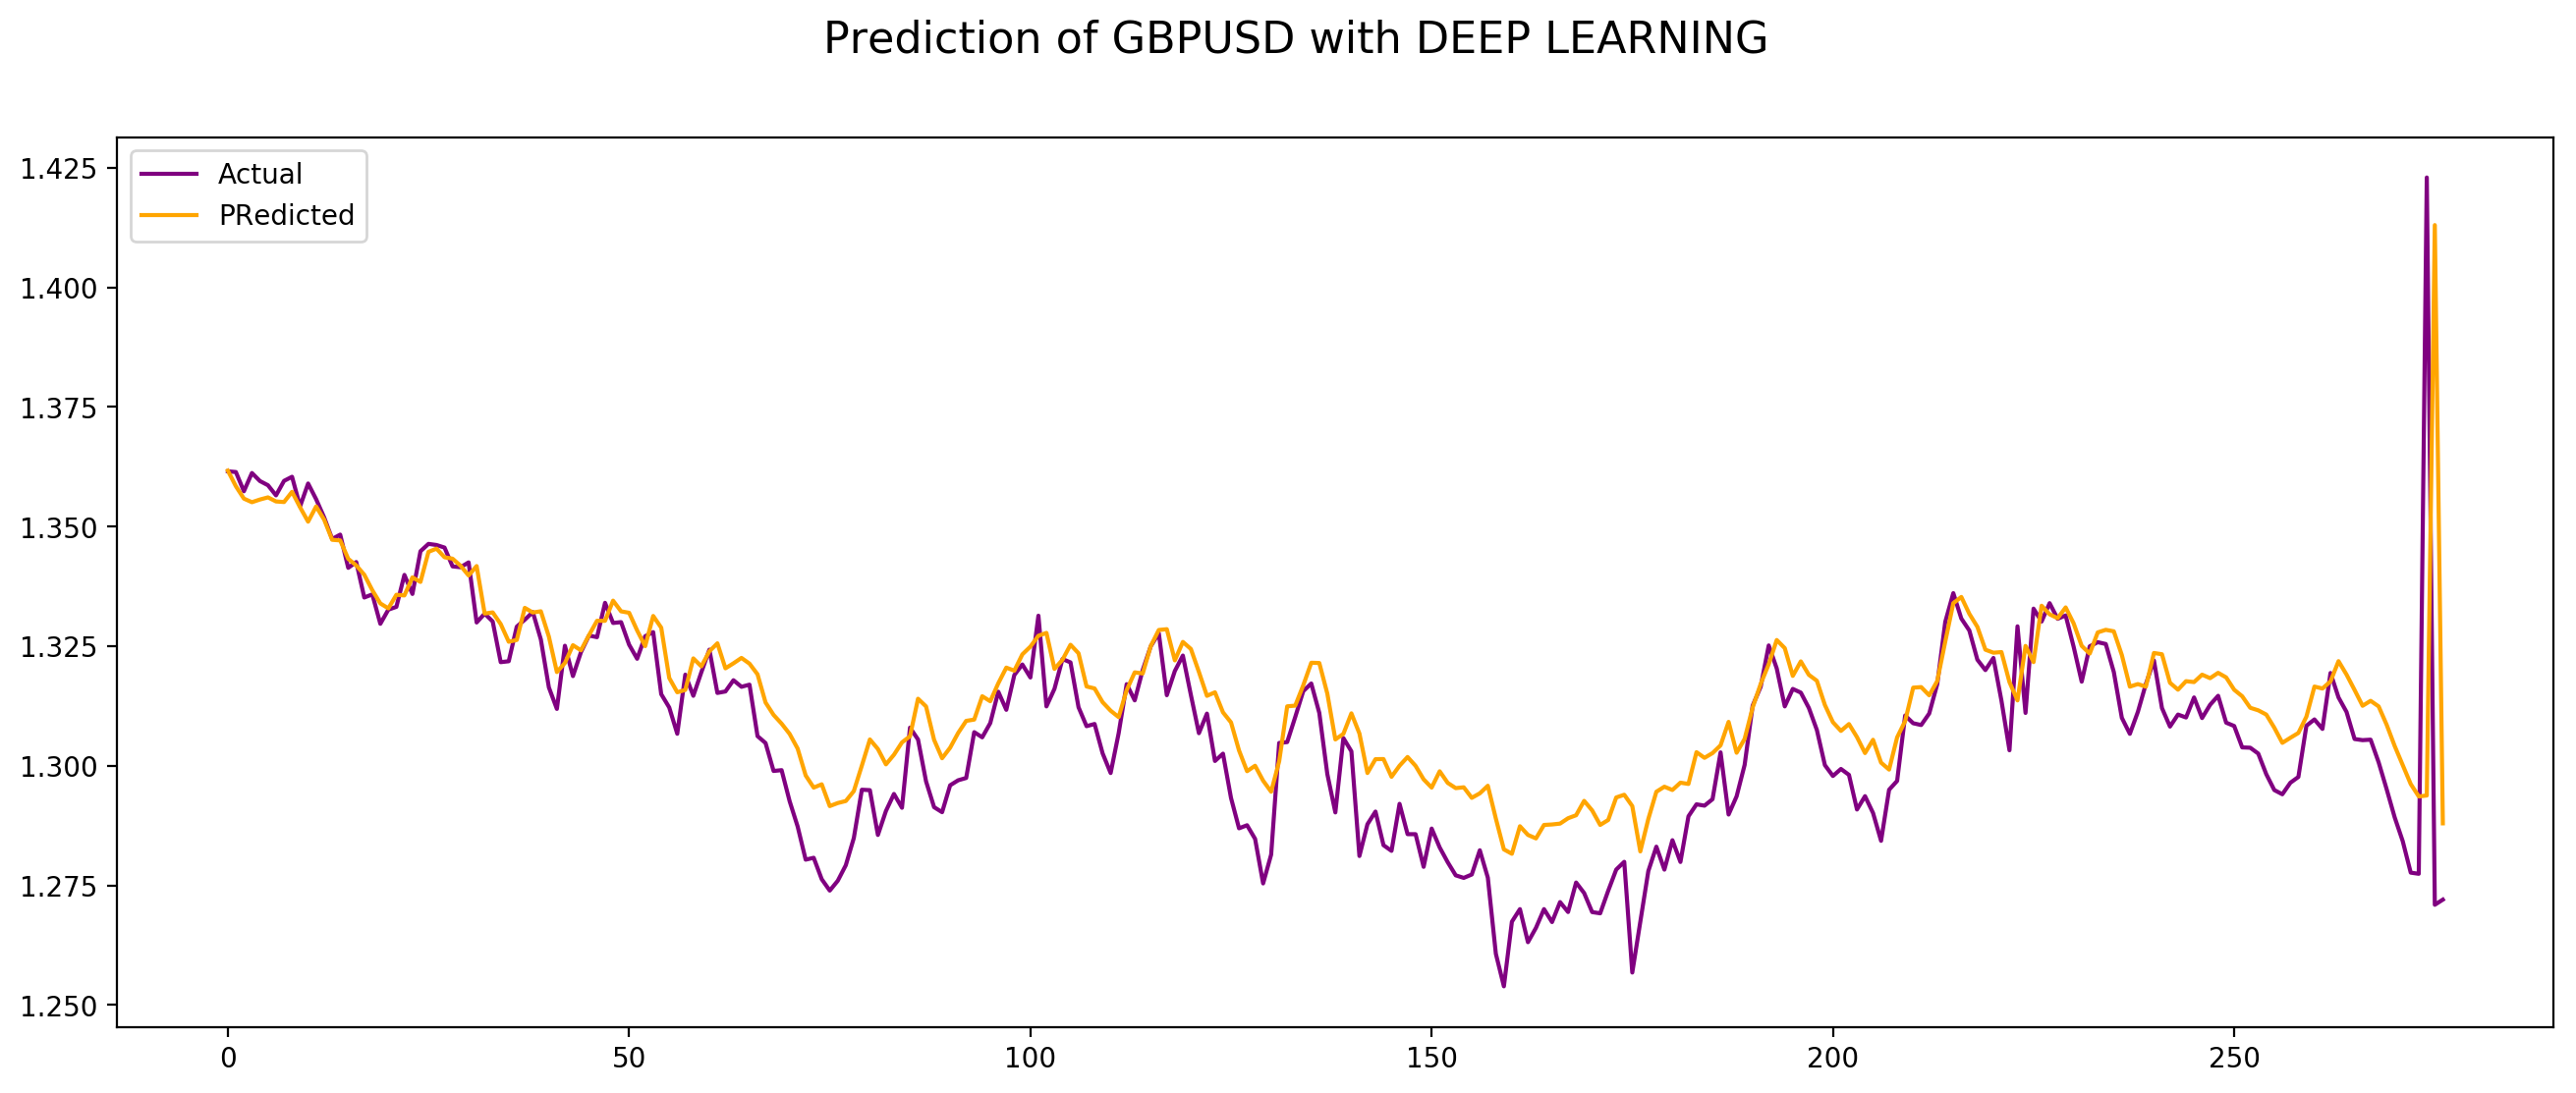

In [118]:
plt.figure(figsize=(16,6),dpi=200)
plt.suptitle('Prediction of GBPUSD with DEEP LEARNING',fontsize=16)
plt.plot(inv_y,color='purple',label='Actual')
plt.plot(inv_yhat,color='orange',label='PRedicted')
plt.legend()
plt.show()